## Blogs to check out for more info about RNNs

[A Beginner’s Guide on Recurrent Neural Networks with PyTorch](https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/)

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Overview paper on RNNs and LSTMs

[Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850)

In [ ]:
#pull in data from github
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt 
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt  
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt

# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM


# physical_devices

## Data Ingestion

In [3]:
# define path to save model
model_path = 'binary_model.h5'

# read training data - It is the aircraft engine run-to-failure data.
# in train data, max cycle per engine = failure point
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Data Preprocessing

In [4]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Useful Life or Time to Failure)

#label each engine with its max cycle
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

#combine max cycle labels with training df
train_df = train_df.merge(rul, on=['id'], how='left')

#subtract current cycle from max cycle to get remaining
train_df['RUL'] = train_df['max'] - train_df['cycle']

#clean out the max cycle column
train_df.drop('max', axis=1, inplace=True)

In [5]:
# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?

#w1 = longer term prediction (30 cycles)
#w0 = shorter term prediction (15 cycles)
w1 = 30
w0 = 15

#label1 = is failure within w1 cycles (binary)
#label2 = how soon is failure (1 = less than w1, 2 = less than w2)
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']

# select sensor columns only (and cycle_norm)
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

# scale sensor columns between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#recombine scaled columns with index/indicator columns
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [6]:
######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

#truth df holds remaining cycles (after test set ends)
truth_df.columns = ['more']

#create engine id for truth
truth_df['id'] = truth_df.index + 1

#can do rowwise ops since rul and truth are ordered by engine number (one row per engine)
#add max cycle from test to remaining cycle from truth
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')

# subtract current cycle from max to get remaining
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## LSTM

In [7]:
#define sequence length
seq_length = 50

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

#create nested list of features for each engine and timestamp sequence
seq_arrays = []
seq_labs = []

#iterate through ids
for idx in train_df['id'].unique():
    id_df = train_df[train_df.id == idx]
    num_rows = len(id_df)
    
    #create list of sequence length feature lists and labels
    for start in range(0,num_rows-seq_length):
        seq_arrays.append(id_df[sequence_cols].iloc[start:start+seq_length].to_numpy())
        seq_labs.append([id_df['label1'].iloc[start:start+seq_length].to_numpy()[-1]])
 
#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [8]:
seq_arrays.shape

(15631, 50, 25)

## Model Training

In [13]:
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_arrays.shape[2]#number of features selected with sequence_cols
nb_out = seq_labs.shape[1]# expected output length

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features), #shape of input layer
         units=100, #number of hidden units
         return_sequences=True))
model.add(Dropout(0.2)) #dropout for regularization

#add second LSTM layer
model.add(LSTM( #don't need to define input since coming from model
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))#classification task w/ sigmoid binary prediction
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) #define parameters

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 100)           50400     
                                                                 
 dropout_6 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
#uncomment this with statement if you don't have or want to use a gpu
#with tf.device('/cpu:0'):
#fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                           keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
              )

# list all data in history
print(history.history.keys())

Epoch 1/100
75/75 - 8s - loss: 0.2737 - accuracy: 0.8819 - val_loss: 0.1052 - val_accuracy: 0.9488 - 8s/epoch - 104ms/step
Epoch 2/100
75/75 - 5s - loss: 0.1047 - accuracy: 0.9576 - val_loss: 0.0691 - val_accuracy: 0.9706 - 5s/epoch - 71ms/step
Epoch 3/100
75/75 - 5s - loss: 0.0930 - accuracy: 0.9634 - val_loss: 0.0636 - val_accuracy: 0.9693 - 5s/epoch - 70ms/step
Epoch 4/100
75/75 - 5s - loss: 0.0666 - accuracy: 0.9712 - val_loss: 0.0662 - val_accuracy: 0.9744 - 5s/epoch - 69ms/step
Epoch 5/100
75/75 - 5s - loss: 0.0729 - accuracy: 0.9714 - val_loss: 0.0356 - val_accuracy: 0.9898 - 5s/epoch - 70ms/step
Epoch 6/100
75/75 - 5s - loss: 0.0647 - accuracy: 0.9724 - val_loss: 0.0484 - val_accuracy: 0.9795 - 5s/epoch - 69ms/step
Epoch 7/100
75/75 - 5s - loss: 0.0644 - accuracy: 0.9727 - val_loss: 0.0503 - val_accuracy: 0.9834 - 5s/epoch - 69ms/step
Epoch 8/100
75/75 - 5s - loss: 0.0638 - accuracy: 0.9731 - val_loss: 0.0412 - val_accuracy: 0.9834 - 5s/epoch - 71ms/step
Epoch 9/100
75/75 - 5s 

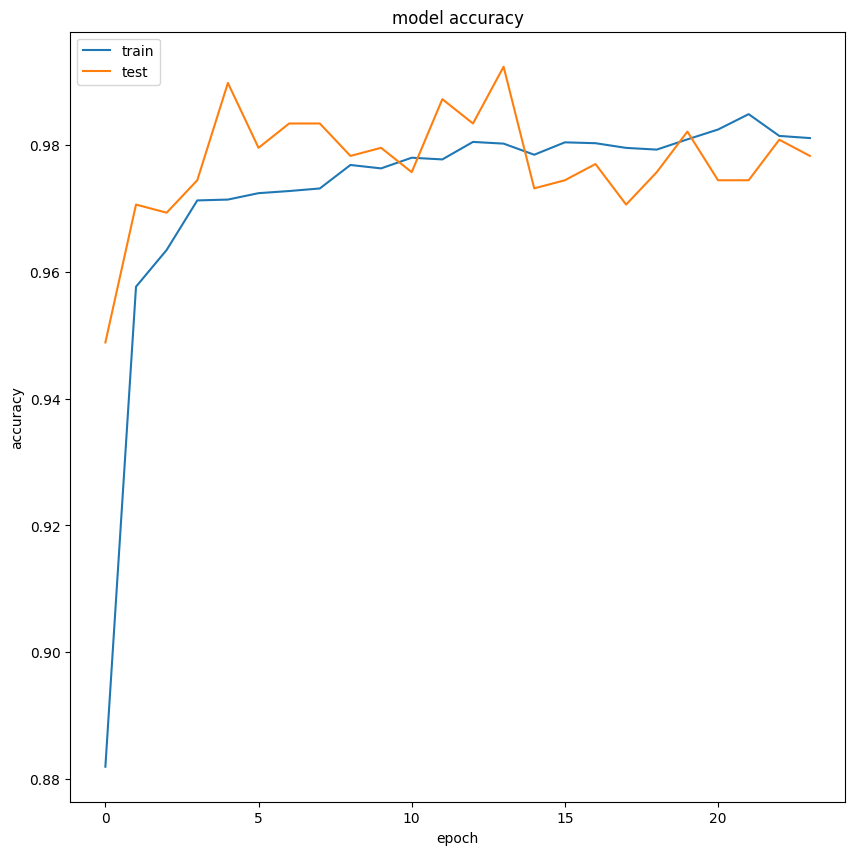

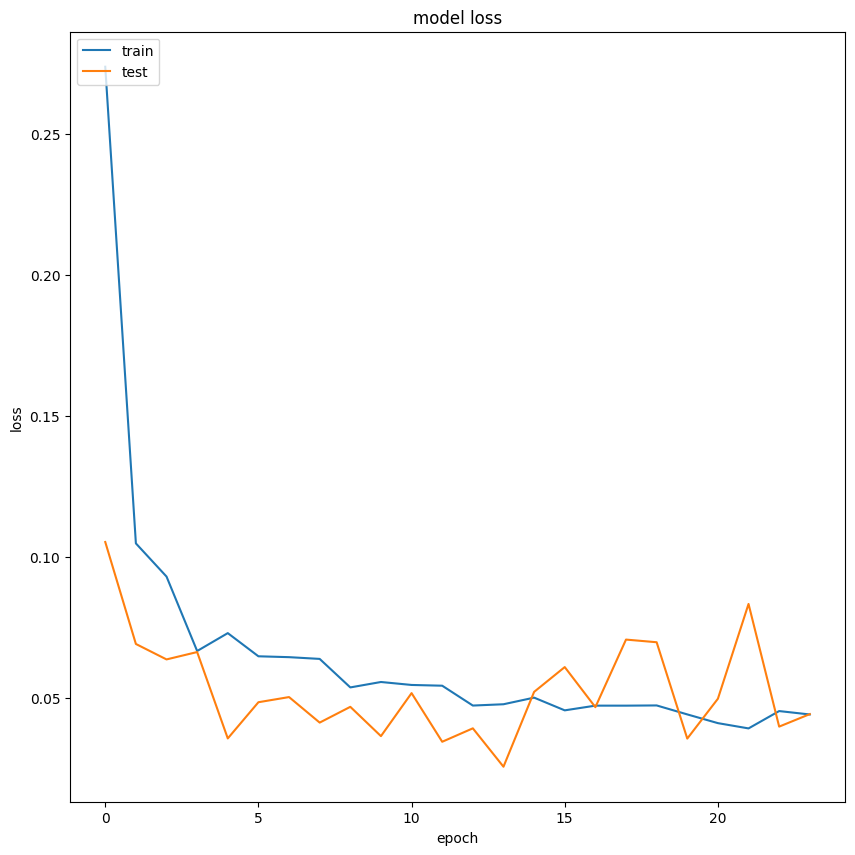

79/79 [==============================] - 2s 30ms/step - loss: 0.0319 - accuracy: 0.9873
Accuracy: 0.98726886510849
79/79 [==============================] - 3s 29ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12495   136]
 [   63  2937]]
precision =  0.955743573055646 
 recall =  0.979


In [15]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_arrays, seq_labs, verbose=1, batch_size=200)
print('Accuracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict(seq_arrays,verbose=1, batch_size=200)
y_true = seq_labs

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred.round(0))
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred.round(0))
recall = recall_score(y_true, y_pred.round(0))
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

3/3 - 0s - loss: 0.0579 - accuracy: 0.9785 - 44ms/epoch - 15ms/step
Accuracy: 0.9784946441650391
3/3 [==============================] - 0s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 1 24]]
Precision:  0.96 
 Recall:  0.96 
 F1-score: 0.96


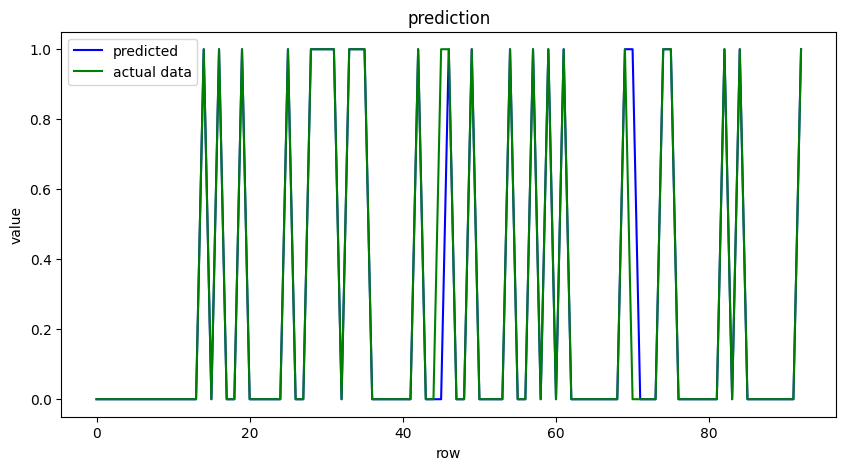

In [16]:
# We pick the last sequence for each id in the validation data

val_arrays = []
val_labs = []

#iterate through ids
for idx in test_df['id'].unique():
    id_df = test_df[test_df.id == idx]
    if len(id_df) >= seq_length:
        val_arrays.append(id_df[sequence_cols].iloc[-seq_length:].to_numpy())
        val_labs.append([id_df['label1'].iloc[-seq_length:].to_numpy()[-1]])

#convert to numpy arrays and floats to appease keras/tensorflow        
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


# test metrics
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test.round(0))
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test.round(0))
recall_test = recall_score(y_true_test, y_pred_test.round(0))
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test.round(0), color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")